# Tutorial on using the Platform

This guide will show you how to use the platform and provide a detailed breakdown of how it works.

## Initialization

First we need to import the necessary class

In [1]:
from commons import qiskit_compilation_enum, normalize_counts, calculate_success_rate_tvd, sum_last_n_digits_dict
import wrappers.qiskit_wrapper as qiskit_wrapper
from wrappers.qiskit_wrapper import QiskitCircuit
import pandas as pd
import mthree

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.options import DynamicalDecouplingOptions

from qiskit_aer import AerSimulator
from qiskit.qasm2 import dumps
import matplotlib.pyplot as plt
import numpy as np

from qEmQUIP import QEM, conf

import mysql.connector

mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'localhost',
    'database': 'framework'
}


CB_color_cycle = ['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A', '#D62728', '#FF9896',
                  '#9467BD', '#C5B0D5', '#8C564B', '#C49C94', '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7',
                  '#BCBD22', '#DBDB8D', '#17BECF', '#9EDAE5'
                  ]

markers = ['o', 'v', '^', 's', '+', '*', 'x', 'd', '<', '>', 'p']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"

# select compilation techniques
compilations = ["qiskit_3", "triq_avg_sabre", "triq_lcd_sabre"]

In [2]:
token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token, skip_db=True)

Connecting to quantum service...
Saving IBM Account...
Retrieving the real backend information of ibm_sherbrooke...


In [3]:
# prepare the circuit
qasm_files = q.get_qasm_files_from_path("./circuits/polar_sim/")
print(qasm_files)

# select compilation techniques
compilations = ["qiskit_3", "triq_avg_sabre", "triq_lcd_sabre"]



./circuits/polar_sim/
['./circuits/polar_sim/polar_all_meas_n3_x.qasm']


### Update the configs from the collected calibration data

To update the fake backend calibration data

In [4]:
q.update_hardware_configs()

In [5]:
# qiskit_wrapper.generate_new_props(q.backend, "avg")
# qiskit_wrapper.generate_new_props(q.backend, "mix")
# qiskit_wrapper.generate_new_props(q.backend, "recent_15_adjust")

# Detailed breakdown

### Set the backend

There are two program types for the backend: `Sampler` or `Estimator`. Here it is also possible to add the options for DynamicalDecoupling (DD) and Twirling, which will be explained later.

In [6]:
q.set_backend(program_type="sampler")

## Prepare the circuits

You can get the quantum circuit from a folder contains the qasm files or qasm string

In [7]:
# The path is coming from the config file, but you can also modify it here
qasm_files = q.get_qasm_files_from_path("./circuits/testing/")
print(qasm_files)

./circuits/testing/
['./circuits/testing/adder_n4.qasm']


Get the circuits from file

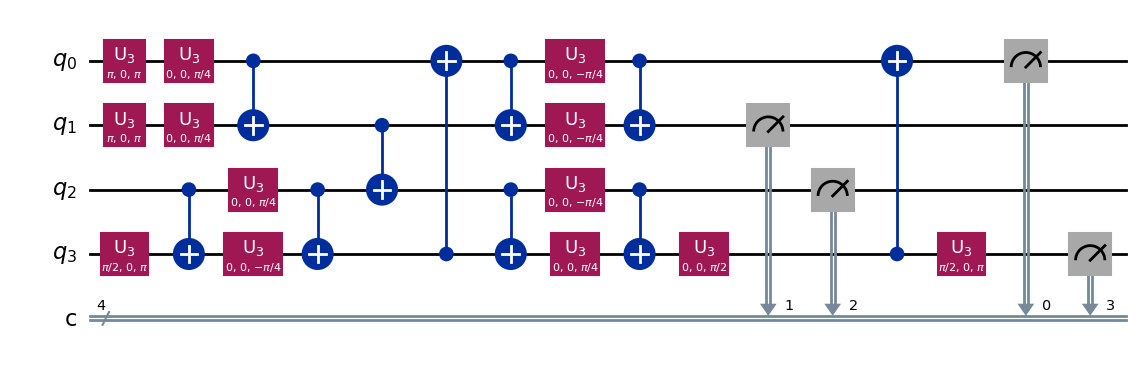

In [8]:
qc = q.get_circuit_properties(qasm_source=qasm_files[0])
qc.circuit.draw("mpl", idle_wires=False, fold=-1)

Or you can also get it from the qasm strings

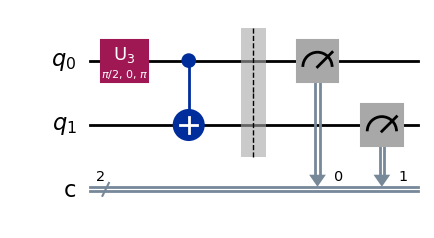

In [9]:
qasm_text = """OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0], q[1];
barrier q[0], q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
"""

qc = q.get_circuit_properties(qasm_source=qasm_text)
qc.circuit.draw("mpl", idle_wires=False, fold=-1)

In [10]:
q.circuit_name

'Circuit_20250205020539'

`q.get_circuit_properties` will give an object of `QiskitCircuit` which will give the information of the circuits: 
- `circuit`: `QuantumCircuit` object from Qiskit
- `depth`: circuit depth
- `gates`: number of gates used in the circuit
- `total_gates`: number of total gates used in the circuit
- `correct_output`: noiseless output from the simulation
- `qasm`: OpenQASM2 file from the circuit translated to `U3` and `cx` gates
- `qasm_original`: OpenQASM2 file from the circuit original


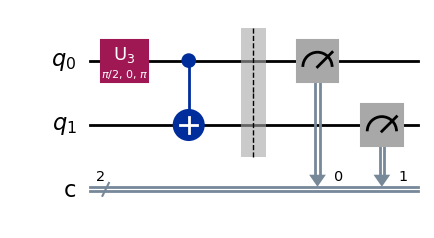

In [11]:
qc.circuit.draw("mpl")

In [12]:
print("Number of depth:", qc.depth)
print("Number of gates:", qc.gates)
print("Number of total gates:", qc.total_gate) 
print("Noiseless simulation output:", qc.correct_output)
print("Circuit Qasm:", qc.qasm)

Number of depth: 3
Number of gates: {'measure': 2, 'u3': 1, 'cx': 1, 'barrier': 1}
Number of total gates: 5
Noiseless simulation output: {'3': 0.4933, '0': 0.5067}
Circuit Qasm: OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u3(pi/2,0,pi) q[0];
cx q[0],q[1];
barrier q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];


## Compilation Techniques

### Qiskit

We integrated several compilation techniques from Qiskit.

Note: After Qiskit 1.0, Noise-Adaptive (NA) initial layout method has been removed.

In [13]:
print("Existing Qiskit Compilation Options:")
for member in qiskit_compilation_enum:
    if not "NA" in member.name:
        print(member.name)

Existing Qiskit Compilation Options:
qiskit_0
qiskit_3
mapomatic_lcd
mapomatic_avg
mapomatic_mix
mapomatic_avg_adj
mapomatic_w15_adj


In [14]:
for member in qiskit_compilation_enum:
    if not "NA" in member.name:
        updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name=member.name)
        print(member.name, initial_mapping)

qiskit_0 [0, 1]
qiskit_3 [124, 125]
mapomatic_lcd [16, 26]
mapomatic_avg [1, 0]
mapomatic_mix [1, 0]
mapomatic_avg_adj [1, 0]
mapomatic_w15_adj [0, 1]


In [15]:
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="qiskit_3")
print(updated_qasm)

OPENQASM 2.0;
include "qelib1.inc";
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }
gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
qreg q[127];
creg c[2];
rz(-pi/2) q[124];
sx q[124];
rz(-2.3419111674042767) q[124];
sx q[124];
rz(-pi/2) q[124];
rz(-pi/2) q[125];
sx q[125];
rz(2.4599343627715466) q[125];
ecr q[125],q[124];
rz(pi/2) q[124];
sx q[124];
rz(-2.3419111674042785) q[124];
rz(-2.252454617613143) q[125];
sx q[125];
rz(pi/2) q[125];
barrier q[124],q[125];
measure q[124] -> c[0];
measure q[125] -> c[1];


### TriQ

Also, we integrate TriQ Compilation with different options.

Qubit placement options:
- `na`: initial mapping from Noise-adaptive technique []
- `mapo`: initial mapping from Mapomatic technique []
- `sabre`: initial mapping from SABRE []

Calibration type options:
- `lcd` : TriQ's routing with last calibration data.
- `avg` : TriQ's routing with average calibration data.
- `mix` : TriQ's routing with mix calibration data. (Mix = if the qubits calibrated today, we will use the last calibration data for that qubit, otherwise we will use the average)

The combinations of name become: `triq_<calibration_type>_<layout>`. For examples:
- `triq_avg_na`
- `triq_mix_sabre`

**Note: From Qiskit version > 1.0.0, `noise_adaptive` layout has been removed**

In [12]:
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="triq_avg_sabre")
#print(updated_qasm)
print("triq_avg_sabre :", initial_mapping)
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="triq_lcd_sabre")
print("triq_lcd_sabre :", initial_mapping)
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="triq_mix_sabre")
print("triq_mix_sabre :", initial_mapping)

triq_avg_sabre : [124, 125]
triq_lcd_sabre : [124, 125]
triq_mix_sabre : [124, 125]


## Initiate Noisy simulator

To play around with the noise, we can get retrieve the last recorded calibration data from IBM's backend, and scale down the error


In [13]:
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)

## Running the compiled circuit to the simulator

First, we need to transpile the circuit to the targeted backend

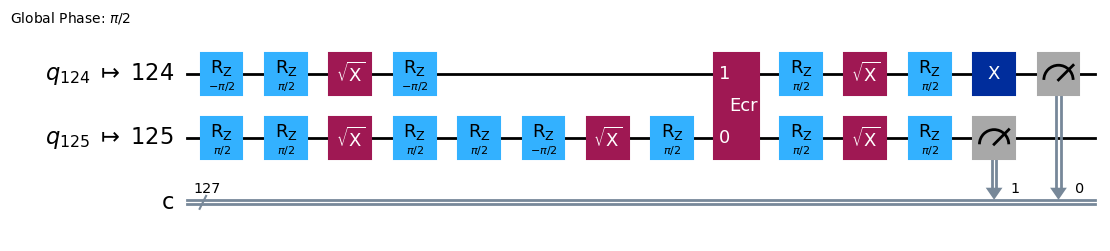

In [14]:
qc = QiskitCircuit(updated_qasm)
circuit = qc.transpile_to_target_backend(q.backend)
circuit.draw("mpl", idle_wires=False, fold=-1)

In [15]:
shots = 5000
q.set_backend(program_type="sampler", backend=noisy_simulator, shots=shots)

In [16]:
job = q.program.run(pubs=[circuit])
result = job.result()[0]
output = result.data.c.get_counts()
output_normalize = normalize_counts(output, shots=shots)
shortened_output = sum_last_n_digits_dict(output, len(initial_mapping))
shortened_output

{'00': 4965, '10': 31, '01': 4}

## Calculate the Fidelity

We use Total Variation Distance (TVD) to calculate the fidelity of the result

In [17]:
fidelity = calculate_success_rate_tvd(qc.correct_output,output_normalize)
fidelity

0.993

## Error Mitigation (mthree)

Matrix-free Measurement Mitigation (M3).

M3 is a measurement mitigation technique that solves for corrected measurement probabilities using a dimensionality reduction step followed by either direct LU factorization or a preconditioned iterative method that nominally converges in O(1) steps, and can be computed in parallel. For example, M3 can compute corrections on 42 qubit GHZ problems in under two seconds on a quad-core machine (depending on the number of unique bitstrings in the output).

You can find more information about M3 [here](https://qiskit-extensions.github.io/mthree/)

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService
qiskit_token = token

QiskitRuntimeService.save_account(channel="ibm_quantum", token=qiskit_token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=qiskit_token)
backend_service = service.backend("ibm_sherbrooke")
backend_sim = AerSimulator.from_backend(backend_service)

In [19]:
#probs_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output, shots)
probs_m3 = q.apply_mthree(backend_sim, initial_mapping, output, shots)
fidelity_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
improvement = (fidelity_m3 - fidelity) / fidelity_m3
print("        Success rate : ", fidelity)
print("Success rate with M3 : ", fidelity_m3)
print("         Improvement : ", improvement)

        Success rate :  0.993
Success rate with M3 :  1.0
         Improvement :  0.007000000000000006


## Dynamical Decoupling

qubits can lose their information over time due to decoherence and can further be influenced by operations applied to other qubits via cross talk. These effects are especially recognizable if the qubits are already initialized in a quantum state but are not being used for an extended period during the calculation.

To eliminate these effects, we can use dynamic decoupling, which adds pulse sequences (known as dynamical decoupling sequences) to flip idle qubits around the Bloch sphere, canceling the effect of noise channels and thereby suppressing the decoherence effect.

You can find more information about the dynamical decoupling [here](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager).

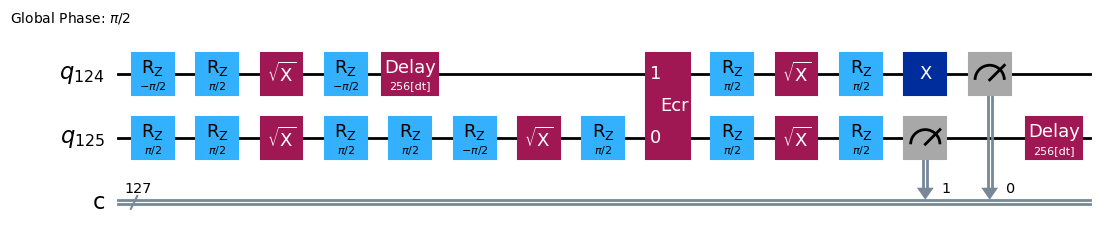

In [20]:
circuit_dd = q.apply_dd(circuit, noisy_simulator, sequence_type="XX", scheduling_method="asap")
circuit_dd.draw("mpl", idle_wires=False, fold=-1)

# Put all of them together

In [13]:
res_circuit_name = []
res_compilations = []
res_noise_levels = []
res_success_rate = []
res_success_rate_dd = []
res_success_rate_m3 = []
res_success_rate_dd_m3 = []

# Prepare the object
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)

# prepare the backend
q.set_backend(program_type="sampler")

# prepare the circuit
qasm_files = q.get_qasm_files_from_path("./circuits/testing/")

shots = 10000

# select compilation techniques
compilations = ["qiskit_0", "triq_avg_sabre", "triq_lcd_sabre"]
# compilations = ["qiskit_0", "qiskit_3"]

# select the noise levels (0 = noiseless, 1 = noise model from real backend)
noise_levels = [0.1, 0.3, 0.5, 0.7, 1.0]


for qasm in qasm_files:
    qc = q.get_circuit_properties(qasm_source=qasm)
    circuit_name = qasm.split("/")[-1].split(".")[0]

    for comp in compilations:    
        updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name=comp)
        compiled_qc = QiskitCircuit(updated_qasm)
        circuit = compiled_qc.transpile_to_target_backend(q.backend)

        print("Circuit : ", circuit_name, ", Compilation : ", comp)
        
        for noise in noise_levels:
            
            noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, noise)
            
            job = noisy_simulator.run(circuit, shots=shots)
            result = job.result()  
            output = result.get_counts()
            output_normalize = normalize_counts(output, shots=shots)

            tvd = calculate_success_rate_tvd(qc.correct_output,output_normalize)

            probs_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output, shots)
            tvd_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
            
            circuit_dd = q.apply_dd(circuit, noisy_simulator, sequence_type="XX", scheduling_method="asap")
            job_dd = noisy_simulator.run(circuit_dd, shots=shots)
            result_dd = job_dd.result()  
            output_dd = result.get_counts()
            output_normalize_dd = normalize_counts(output_dd, shots=shots)

            tvd_dd = calculate_success_rate_tvd(qc.correct_output,output_normalize)

            probs_dd_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output_dd, shots)
            tvd_dd_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
            
            
            print("Noise level :", noise, "- sr :", np.round(tvd,4), ", sr m3:", np.round(tvd_m3,4),
                  ", sr dd :", np.round(tvd_dd,4), ", sr dd m3:", np.round(tvd_dd_m3,4))
            res_circuit_name.append(circuit_name)
            res_compilations.append(comp)
            res_noise_levels.append(noise)
            res_success_rate.append(tvd)
            res_success_rate_m3.append(tvd_m3)
            res_success_rate_dd.append(tvd_dd)
            res_success_rate_dd_m3.append(tvd_dd_m3)

        


Connecting to quantum service...
Saving IBM Account...
Retrieving the real backend information of ibm_sherbrooke...
./circuits/testing/
Circuit :  adder_n4 , Compilation :  qiskit_0
Noise level : 0.1 - sr : 0.9769 , sr m3: 0.9769 , sr dd : 0.9769 , sr dd m3: 0.9769
Noise level : 0.3 - sr : 0.9248 , sr m3: 0.9249 , sr dd : 0.9248 , sr dd m3: 0.9249
Noise level : 0.5 - sr : 0.886 , sr m3: 0.8861 , sr dd : 0.886 , sr dd m3: 0.8861
Noise level : 0.7 - sr : 0.8412 , sr m3: 0.8414 , sr dd : 0.8412 , sr dd m3: 0.8414
Noise level : 1.0 - sr : 0.7864 , sr m3: 0.7865 , sr dd : 0.7864 , sr dd m3: 0.7865
Circuit :  adder_n4 , Compilation :  triq_avg_sabre
Noise level : 0.1 - sr : 0.9759 , sr m3: 0.976 , sr dd : 0.9759 , sr dd m3: 0.976
Noise level : 0.3 - sr : 0.9357 , sr m3: 0.9359 , sr dd : 0.9357 , sr dd m3: 0.9359
Noise level : 0.5 - sr : 0.8783 , sr m3: 0.8784 , sr dd : 0.8783 , sr dd m3: 0.8784
Noise level : 0.7 - sr : 0.8483 , sr m3: 0.8486 , sr dd : 0.8483 , sr dd m3: 0.8486
Noise level : 

## Plot the results

In [15]:
df = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate,
    })

df_dd = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate_dd,
    })

df_m3 = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate_m3
    })

df_dd_m3 = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate_dd_m3
    })

### Combined plot

In [16]:
def create_line_chart_combined(data, y, opt_values, metric, ax, type, ylabel, xlabel, yticks = None, 
                      y_bot = None, y_top = None, figsize = (12,8), c_idx = 0, reindex = None, x_index = "header_id", x_labels = [], i=0):
    tmp = ()
    
    for idx, opt in enumerate(opt_values):
        # print(idx, opt)
        idx_marker = idx + (len(opt_values) * i)
        # idx = idx 
        pivot = pd.pivot_table(data[data[y] == opt], 
                               values=[metric], 
                               index=x_index, 
                               columns=y, 
                               aggfunc='mean')    
        if reindex != 0:
            if reindex is None:
                if len(tmp) == 0:
                    tmp = pivot.index
                else:
                    pivot = pivot.reindex(tmp)
            else:
                pivot = pivot.reindex(reindex)

        idx_color = (idx % (len(markers)))
        # print(idx_color, idx, len(markers))

        # print (pivot)
         
        pivot.plot(kind='line', color=CB_color_cycle[idx], marker=markers[idx], linestyle=linestyles[i], figsize=figsize, ax=ax)

        mean= pivot.mean().mean()

    if i == i:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
    
        if yticks is not None:
            ax.set_yticks(yticks)
    
        if y_bot is not None and y_top is not None:
            ax.set_ylim(bottom= y_bot, top= y_top)
    
        if x_labels is not None:
            ax.set_xticks(np.arange(len(x_labels)))
            ax.set_xticklabels(x_labels)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
        ax.grid()


In [17]:
def show_figure_by_opt_combined(dfs, y, y_values, metric, ylabel, xlabel, legend = None, figsize=(10,6), reindex=None, 
                             x_index = "total_2q", x_labels = [], x_lim = [1, 100], 
                            y_lim = [0,1], title=None, legend_position=None, circuit_name = "", hw_name = ""):
    # y_values = noise_levels

    metrics = [metric]
    row = 1
    col = 1

    fig, ax = plt.subplots(nrows=row, ncols=1)

    yticks = None
    
    for i in range(len(dfs)):
        # print(i)
        create_line_chart_combined(dfs[i], y, y_values, metrics[0], ax, "opt", ylabel, xlabel, yticks, figsize=figsize, reindex=reindex,
                          x_index = x_index, x_labels=x_labels, i=i)

    # n=[]        
    # n.append(ax.axhline(np.NaN, color="gray", linestyle='-.'))

    # l1 = ax.legend(n, ["Mean"], loc=[0.82, 0.49])

    if legend is None:
            l2 = plt.legend()
    else:
        if legend_position == None:
            l2 = plt.legend(legends)
        else:
            l2 = plt.legend(legends, loc = legend_position)
    
    # plt.tight_layout()
    # ax.add_artist(l1)
    plt.xlim(x_lim) 
    plt.ylim(y_lim)
    plt.title(title)
    #plt.savefig("./output/{}_{}_{}.png".format(circuit_name, hw_name, x_index), dpi=500, bbox_inches='tight')
    plt.show()
    
    return plt

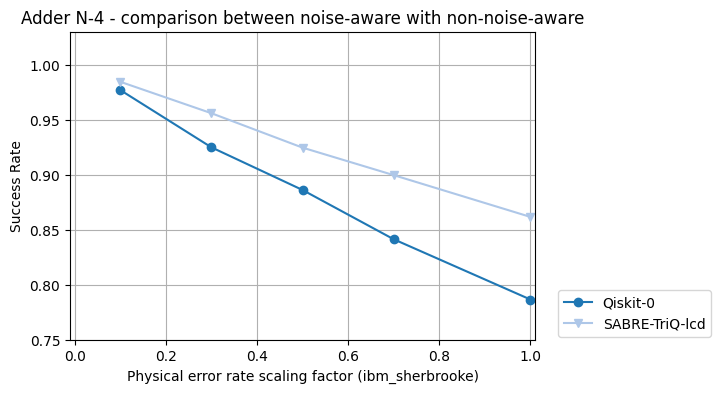

In [23]:
y_values = ["qiskit_0", "triq_lcd_sabre"]
legends  = ["Qiskit-0", "SABRE-TriQ-lcd"
           ]
x_lim=[-0.01, 1.01]
y_lim=[0,1.03]
legend_position=(0.01,0.01)
circuit_name = "adder"
hw_name = "sherbrooke"
title="Adder N-4 - comparison between noise-aware with non-noise-aware"
x_index = "noise_level"

# print(y_values)
x_labels = None
dfs = [df]

plt = show_figure_by_opt_combined(dfs, "compilation", y_values, "success_rate", "Success Rate", "Physical error rate scaling factor (ibm_sherbrooke)", legends, figsize=(6,4), 
                   reindex=None, x_index = "noise_level", x_labels=x_labels, x_lim=[-0.01, 1.01], y_lim=[0.75,1.03],legend_position=(1.05,0.01),
                       circuit_name = "adder_n7", hw_name = hw_name, title=title)

In [22]:
y_values = ["qiskit_0", "triq_avg_sabre", "triq_lcd_sabre"]
legends  = ["Qiskit-0", "SABRE-TriQ-avg", "SABRE-TriQ-lcd",
            "Qiskit-0 (M3)", "SABRE-TriQ-avg (M3)", "SABRE-TriQ-lcd (M3)"]

x_lim=[0.7, 1.01]
y_lim=[0,1.03]
legend_position=(0.01,0.01)
circuit_name = "adder"
hw_name = "sherbrooke"
title="Adder N-4 - comparison before and after M3"
x_index = "noise_level"

# print(y_values)
x_labels = None
dfs = [df, df_m3]

#plt = show_figure_by_opt_combined(dfs, "compilation", y_values, "success_rate", "Success Rate", "Physical error rate scaling factor (ibm_sherbrooke)", legends, figsize=(6,4), 
#                   reindex=None, x_index = "noise_level", x_labels=x_labels, x_lim=[-0.01, 1.01], y_lim=[0.75,1.03],legend_position=(1.05,0.01),
#                       circuit_name = "adder_n7", hw_name = hw_name, title=title)

## Quick Run

### Send to real backend

In [24]:
# prepare the circuit
qasm_files = q.get_qasm_files_from_path("./circuits/testing/")
print(qasm_files)

# select compilation techniques
compilations = ["qiskit_3", "triq_lcd_sabre"]

token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"

./circuits/testing/
['./circuits/testing/adder_n4.qasm']


In [ ]:
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)
q.send_to_real_backend("sampler", qasm_files, compilations)

In [ ]:
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)

dd_options: DynamicalDecouplingOptions = {
    'enable':True, 
    'sequence_type':'XpXm',
    'scheduling_method': 'alap'
} 

q.send_to_real_backend("sampler", qasm_files, compilations, dd_options = dd_options)

### Send to simulator

#### Sampler

In [28]:
# prepare the circuit
qasm_files = q.get_qasm_files_from_path("./circuits/testing/")

noise_levels = [0.6, 0.8, 1.0]
shots = 10000
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)
q.run_simulator("sampler", qasm_files, compilations, noise_levels, shots, send_to_db=True)


./circuits/testing/
Connecting to quantum service...
Saving IBM Account...
Retrieving the real backend information of ibm_sherbrooke...
Start running the simulator...
qiskit_3 0.6
qiskit_3 0.8
qiskit_3 1.0
triq_lcd_sabre 0.6
triq_lcd_sabre 0.8
triq_lcd_sabre 1.0
Total send to local simulator : 6
Running to Local Simulator with batch id: 1494 ... 
Sent!
Running to Local Simulator with batch id: 1495 ... 
Sent!
Running to Local Simulator with batch id: 1496 ... 
Sent!
Running to Local Simulator with batch id: 1497 ... 
Sent!
Running to Local Simulator with batch id: 1498 ... 
Sent!
Running to Local Simulator with batch id: 1499 ... 
Sent!


## Get the result

In [31]:
q.get_qiskit_result()

Pending jobs:  1
Checking results for:  simulator with header id : 1499
Preparing the noisy simulator ibm_sherbrooke qiskit_3 0.6 False
Preparing the noisy simulator ibm_sherbrooke qiskit_3 0.8 False
Preparing the noisy simulator ibm_sherbrooke qiskit_3 1.0 False
Preparing the noisy simulator ibm_sherbrooke sabre_triq_lcd 0.6 False
Preparing the noisy simulator ibm_sherbrooke sabre_triq_lcd 0.8 False
Preparing the noisy simulator ibm_sherbrooke sabre_triq_lcd 1.0 False
Executed jobs : 1
Getting qasm for : 1499 simulator


In [38]:
conn = mysql.connector.connect(**mysql_config)
cursor = conn.cursor()

sql = """
SELECT header_id, circuit_name, compilation_name, noise_level, success_rate_tvd, total_two_qubit_gate, initial_mapping
FROM result WHERE header_id = 1499;
""".format(1, "ibm_sherbrooke")

 # insert to circuit
cursor.execute(sql)

results = cursor.fetchall()

cursor.close()
conn.close()

In [40]:
header_id = []
circuit_name = []
compilation_name = []
noise_level = []
success_rate_tvd = []
total_gate_cx = []
initial_mappings = []


for res in results:
    _header_id, _circuit_name, _compilation_name , _noise_level, \
    _success_rate_tvd, _total_gate_cx, _initial_mappings = res

    header_id.append(_header_id)
    circuit_name.append(_circuit_name)
    compilation_name.append(_compilation_name)
    noise_level.append(float(_noise_level))
    success_rate_tvd.append(float(_success_rate_tvd))
    total_gate_cx.append(float(_total_gate_cx))
    initial_mappings.append(_initial_mappings)

df = pd.DataFrame({
    'header_id': header_id,
    'circuit_name': circuit_name,
    'compilation_name': compilation_name,
    'noise_level': noise_level,
    'success_rate_tvd': success_rate_tvd,
    'total_gate_cx': total_gate_cx,
    'noise_level': noise_level,
    'initial_mappings': initial_mappings
    })

In [43]:
df

,header_id,circuit_name,compilation_name,noise_level,success_rate_tvd,total_gate_cx,initial_mappings
0,1499,adder_n4,qiskit_3,0.6,0.9099,16.0,"112, 126, 125, 124"
1,1499,adder_n4,qiskit_3,0.8,0.8737,16.0,"112, 126, 125, 124"
2,1499,adder_n4,qiskit_3,1.0,0.8478,16.0,"112, 126, 125, 124"
3,1499,adder_n4,sabre_triq_lcd,0.6,0.9125,22.0,"112, 126, 125, 124"
4,1499,adder_n4,sabre_triq_lcd,0.8,0.8906,22.0,"112, 126, 125, 124"
5,1499,adder_n4,sabre_triq_lcd,1.0,0.8492,22.0,"112, 126, 125, 124"


#### Estimator

**Under progress, still not working!!**

circuits = []
observables = []

circuits.append("""OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
h q[0];
cx q[0],q[1];
cx q[1],q[2];""")

observables.append(['ZZZ','ZII','IXI','IZI','XII','XXX'])

noise_levels = [0.6, 0.8, 1.0]
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)
df = q.run_simulator("estimator", circuits, compilations, noise_levels, shots, observables=observables, send_to_db=False)
df


# Mitiq (Pending)

In [5]:
import mitiq
from mitiq import benchmarks
frontend = "qiskit"
print(mitiq.SUPPORTED_PROGRAM_TYPES.keys())
print(mitiq.qem_methods())
shots = 10000

from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne import execute_with_zne
from mitiq.zne.scaling import (
    fold_gates_at_random,
    fold_global,
    fold_all
)
from mitiq.zne.inference import LinearFactory, RichardsonFactory
from mitiq import (
    Calibrator,
    Settings,
    execute_with_mitigation,
    MeasurementResult,
)

from qiskit_ibm_runtime.fake_provider import FakeJakartaV2  # Fake (simulated) QPU

from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ECRGate
from qiskit.circuit.library import RZXGate
from mitiq import zne
from mitiq.interface import convert_to_mitiq

['braket', 'cirq', 'pennylane', 'pyquil', 'qibo', 'qiskit']
{'mitiq.cdr': 'Clifford Data Regression', 'mitiq.ddd': 'Digital Dynamical Decoupling', 'mitiq.pec': 'Probabilistic Error Cancellation', 'mitiq.pt': 'Pauli Twirling', 'mitiq.qse': 'Quantum Subspace Expansion', 'mitiq.rem': 'Readout Error Mitigation (confusion inversion)', 'mitiq.zne': 'Zero Noise Extrapolation'}


### ZNE

In [25]:
q.set_backend(program_type="sampler")
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)

Time for setup the backends: 8.924200028559426e-05 seconds


['./circuits/testing/adder_n7.qasm']


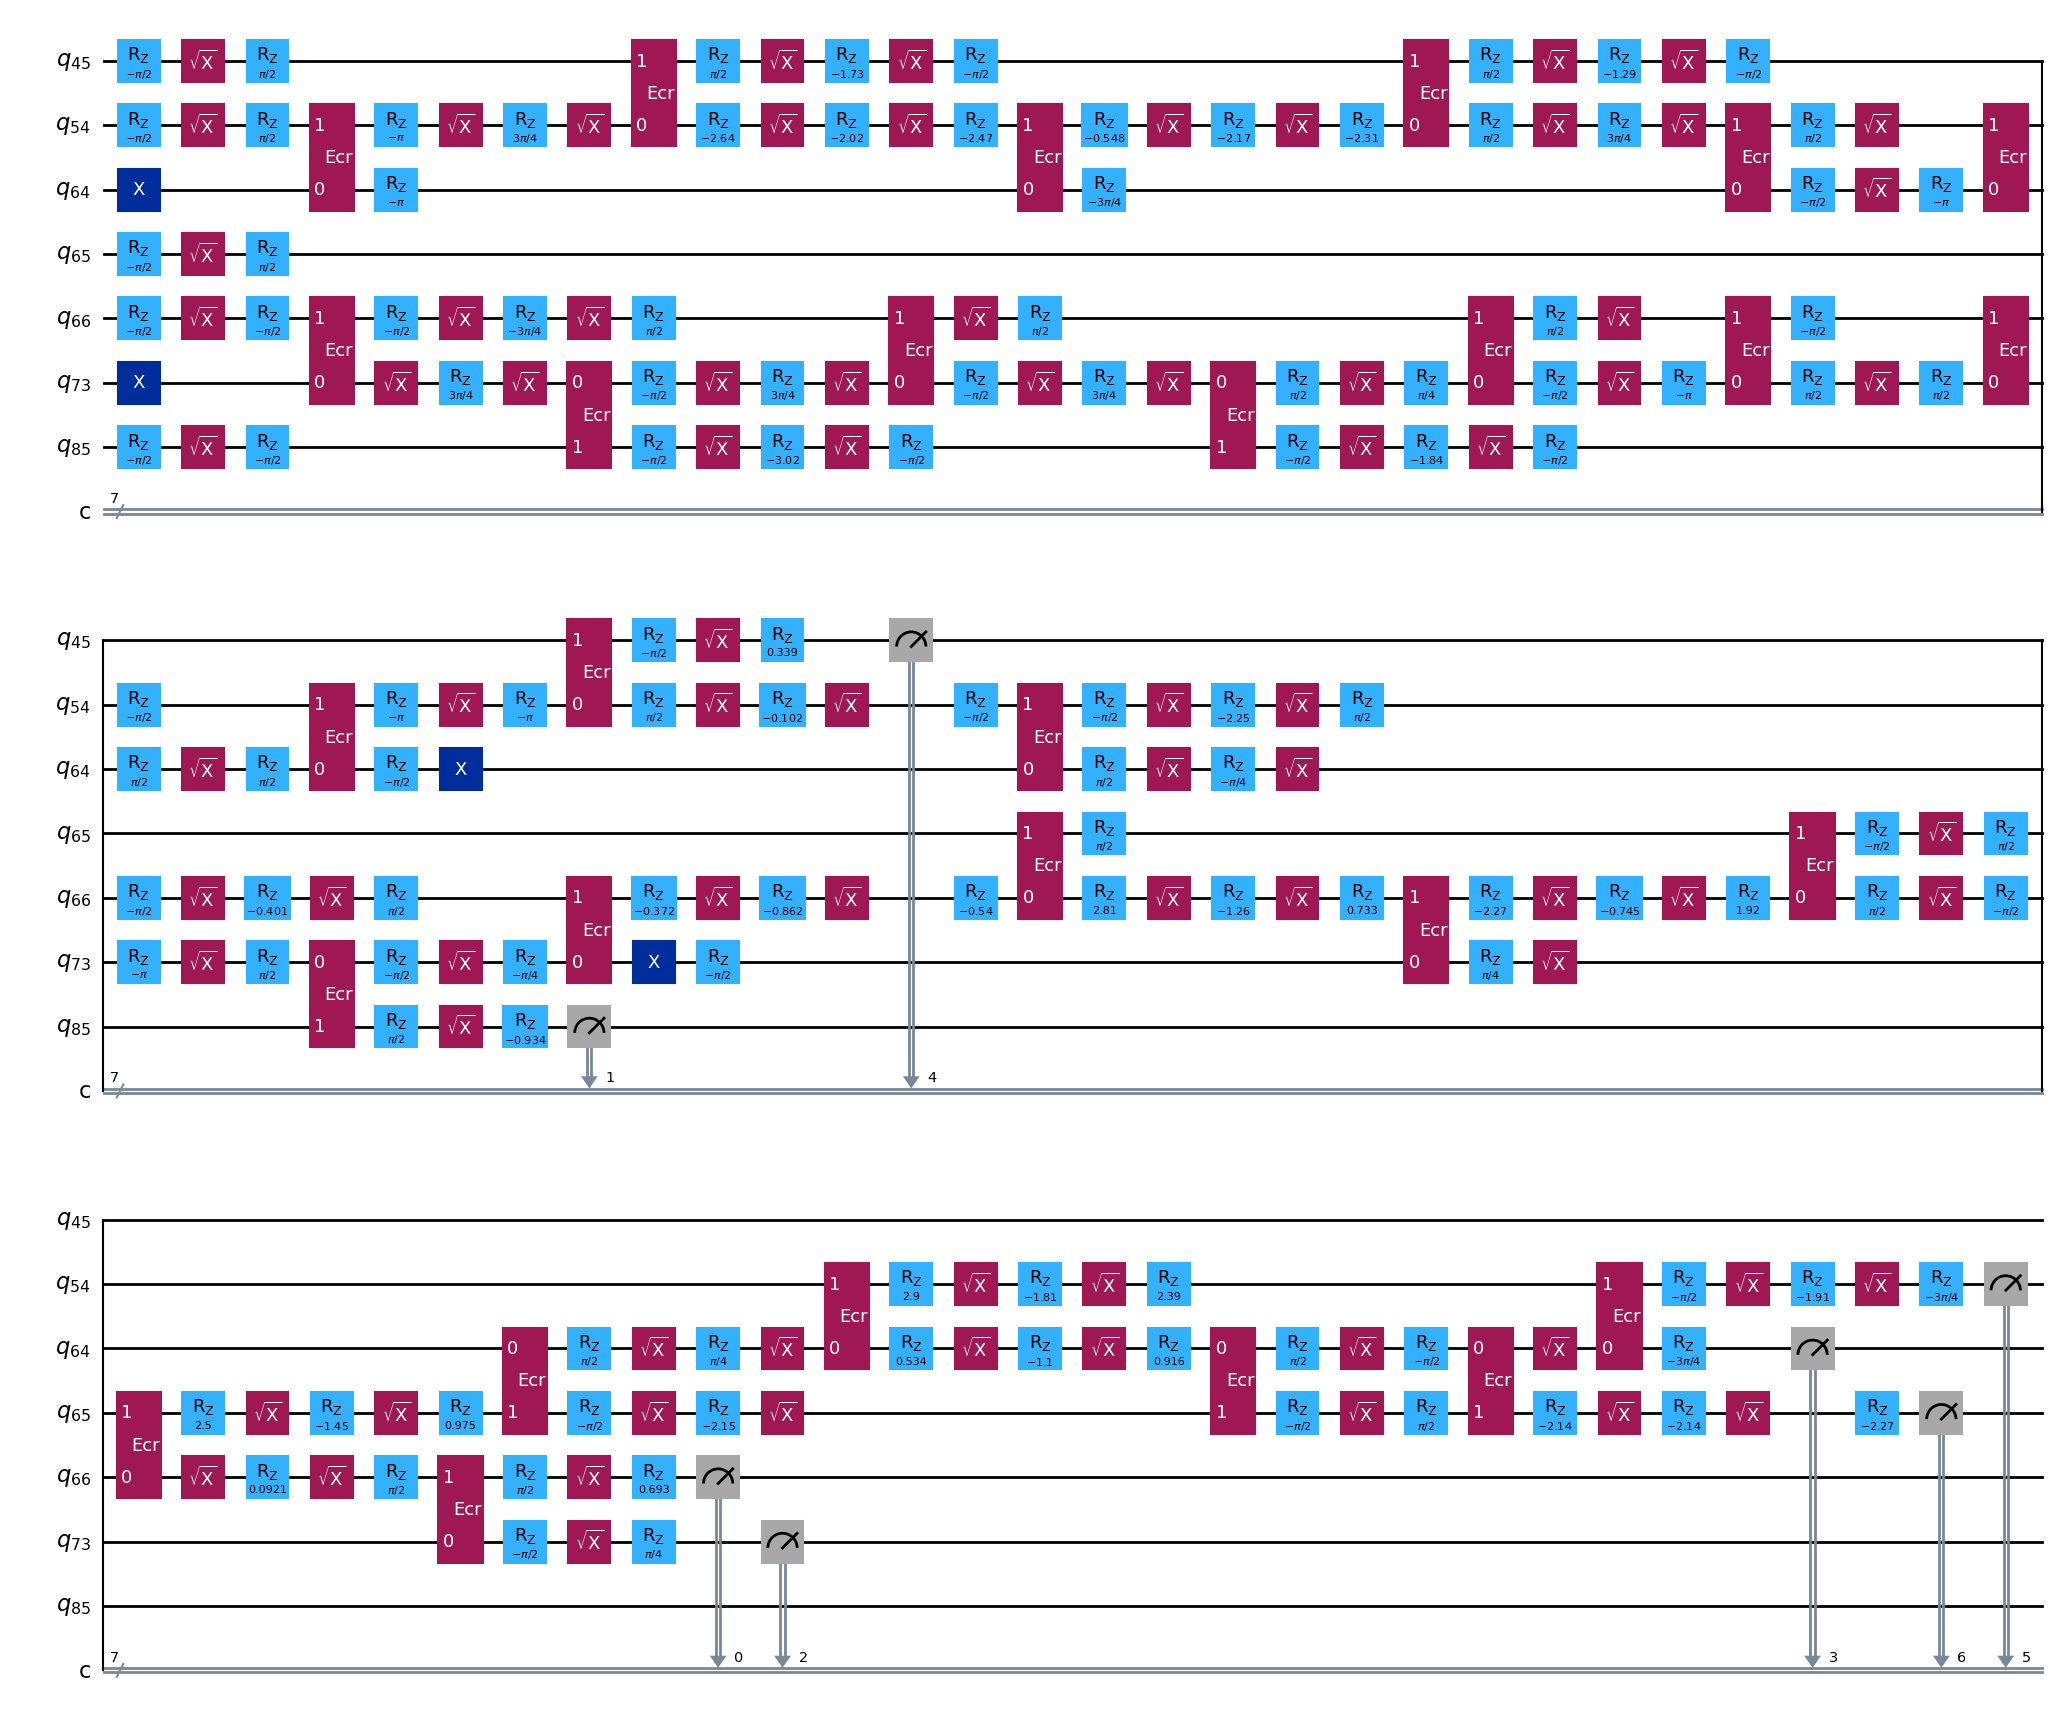

In [26]:
# The path is coming from the config file, but you can also modify it here
qasm_files = q.get_qasm_files_from_path("./circuits/testing/")
print(qasm_files)

qc = q.get_circuit_properties(qasm_source=qasm_files[0])
qc.circuit.draw(idle_wires=False)

#qc = QuantumCircuit(2)
#qc.x(0)
#qc.barrier(0,1)
#qc.cx(0,1)
#qc.measure_all()

#pm = generate_preset_pass_manager(optimization_level=1, backend=noisy_simulator)
#isa_circuit = pm.run(qc.circuit)

#print(dumps(isa_circuit))
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="qiskit_3")
compiled_qc = QuantumCircuit.from_qasm_str(updated_qasm)
compiled_qc.draw("mpl", idle_wires=False, fold=30)

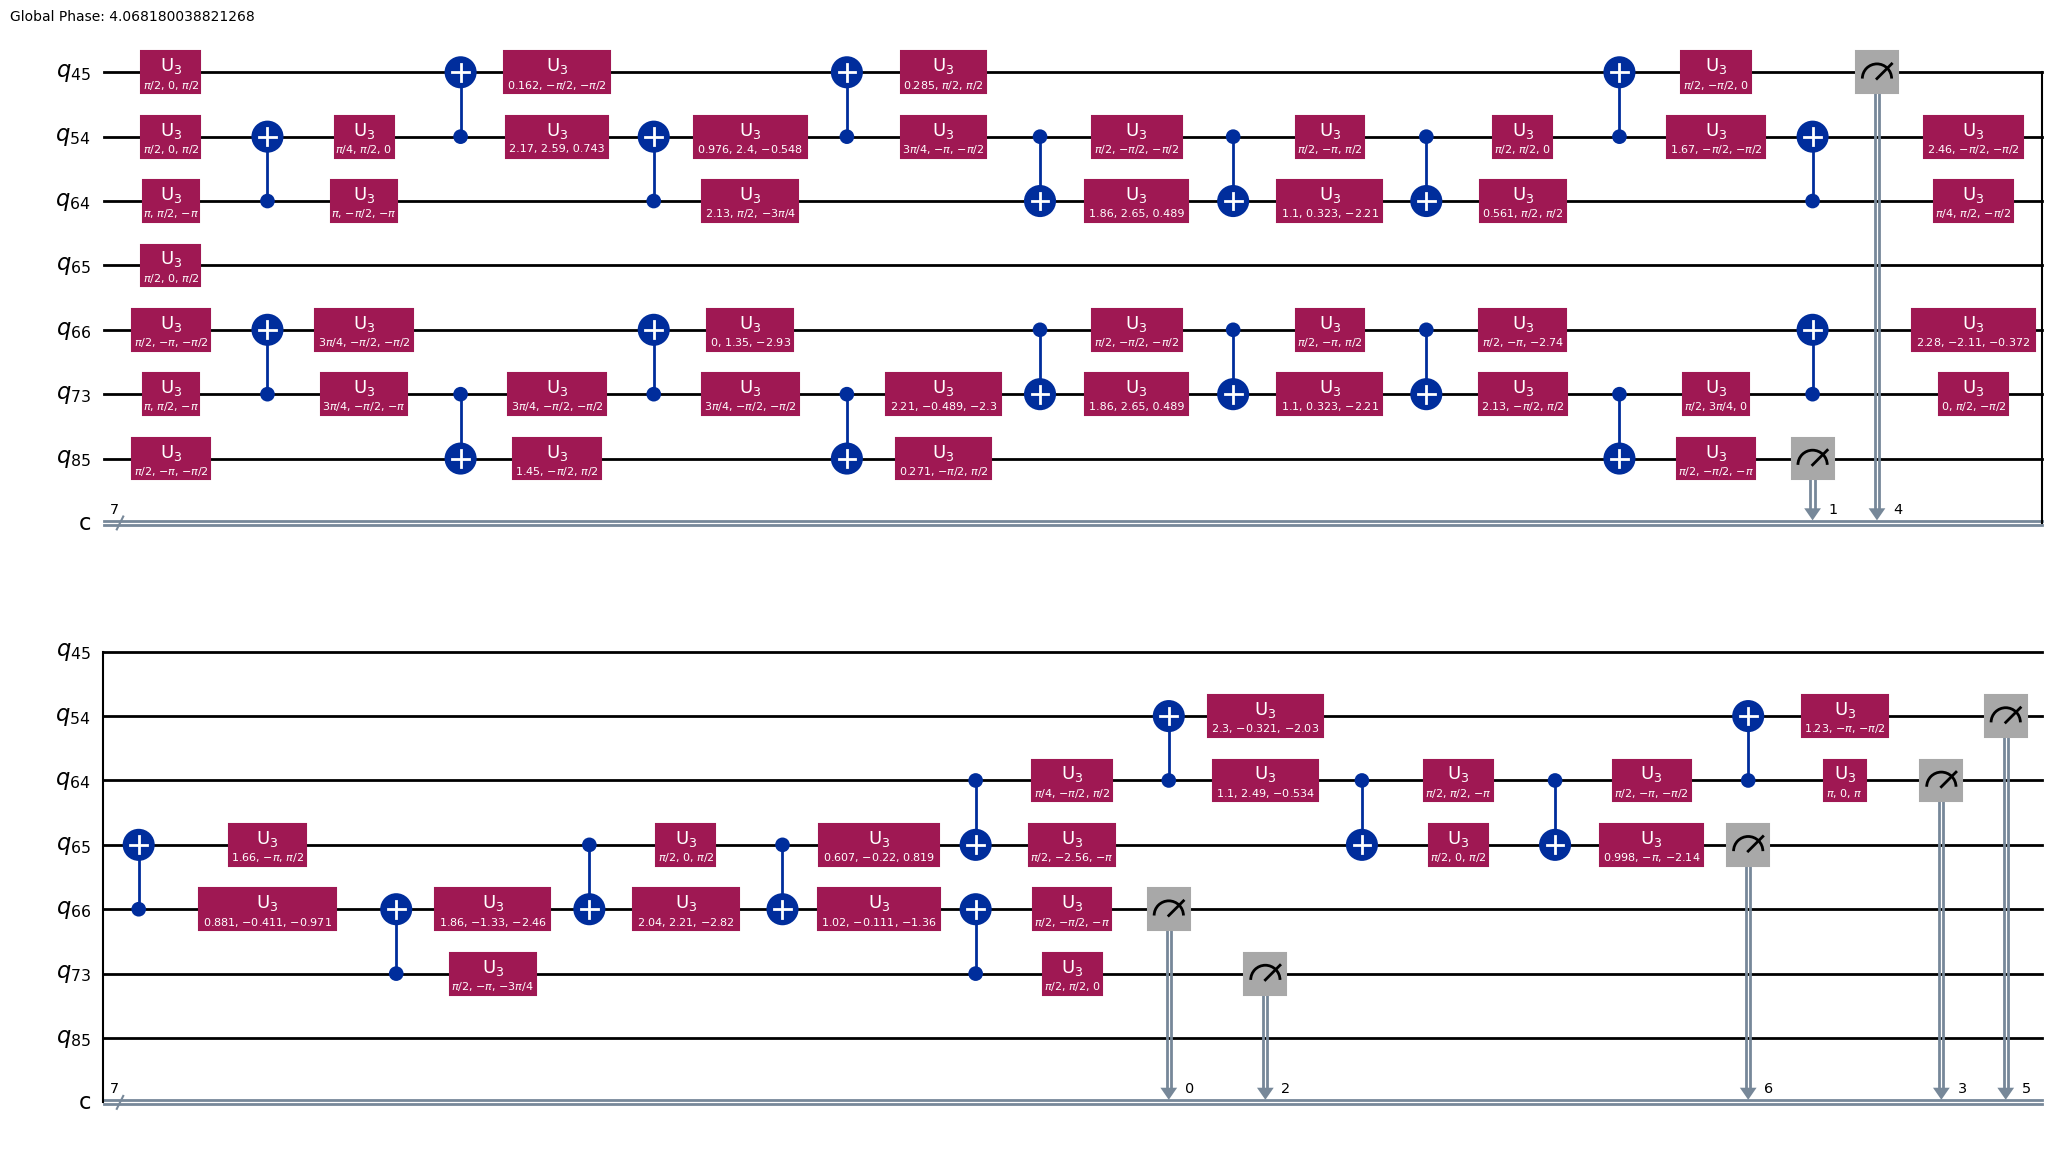

In [27]:
n_qubits = 10
depth_circuit = 100
shots = 10 ** 4

#circuit = generate_rb_circuits(n_qubits, depth_circuit,return_type="qiskit")[0]
#circuit.measure_all()

#qc = q.get_circuit_properties(qasm_source=dumps(circuit))

#updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="qiskit_0")
#compiled_qc = QuantumCircuit.from_qasm_str(updated_qasm)
#compiled_qc.draw("mpl", idle_wires=False, fold=30)

#circuit = compiled_qc
circuit = transpile(compiled_qc, basis_gates=["u3","cx"], optimization_level=3)
circuit.draw("mpl", idle_wires=False, fold=30)

In [34]:
job = noisy_simulator.run(circuit, shots=shots)
result = job.result()  
output = result.get_counts()
output_normalize = normalize_counts(output, shots=shots)

In [35]:
def execute_circuit(circuit):
    """Execute the input circuit and return the expectation value of |00..0><00..0|"""
    noisy_backend = noisy_simulator
    noisy_result = noisy_backend.run(circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(circuit)
    print(noisy_counts["1111011"])
    noisy_expectation_value = noisy_counts["1111011"] / shots
    return noisy_expectation_value

In [36]:
mitigated = execute_with_zne(circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated = execute_circuit(circuit)
ideal = 1 #property of RB circuits

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))

915969
915528
916290
915852
ideal = 	 	 1
unmitigated = 	 	 0.91585
mitigated = 	 	 0.91569


In [31]:
def execute_calibration(qiskit_circuit):
    """Execute the input circuits and return the measurement results."""
    noisy_backend = noisy_simulator
    noisy_result = noisy_backend.run(qiskit_circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(qiskit_circuit)
    noisy_counts = { k.replace(" ",""):v for k, v in noisy_counts.items()}
    measurements = MeasurementResult.from_counts(noisy_counts)
    return measurements

In [ ]:
RBSettings = Settings(
    benchmarks=[
        {
            "circuit_type": "rb",
            "num_qubits": 2,
            "circuit_depth": int(depth_circuit / 2),
        },
    ],
    strategies=[
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

    ],
)

In [ ]:
cal = Calibrator(execute_calibration, frontend="qiskit", settings=RBSettings)
cal.run(log="flat")

In [ ]:
calibrated_mitigated=execute_with_mitigation(circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated=execute_circuit(circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

#### Tutorial ZNE Mitiq with Qiskit

In [ ]:
import qiskit
from qiskit_aer import QasmSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise
USE_REAL_HARDWARE = False

In [ ]:
qreg, creg = qiskit.QuantumRegister(1), qiskit.ClassicalRegister(1)
circuit = qiskit.QuantumCircuit(qreg, creg)
for _ in range(50):
    circuit.x(qreg)
circuit.measure(qreg, creg)
print(circuit)

In [ ]:
if QiskitRuntimeService.saved_accounts() and USE_REAL_HARDWARE:
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    noise_model = False
else:
    # Simulate the circuit with noise
    noise_model = initialized_depolarizing_noise(noise_level=0.02)
    # Default to a simulator
    backend = noisy_simulator


def ibmq_executor(circuit: qiskit.QuantumCircuit, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    # Transpile the circuit so it can be properly run
    exec_circuit = qiskit.transpile(
        circuit,
        backend=backend,
        basis_gates=noise_model.basis_gates if noise_model else None,
        optimization_level=0, # Important to preserve folded gates.
    )
    
    # Run the circuit
    job = backend.run(circuit, shots=shots)

    # Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    if counts.get("0") is None:
        expectation_value = 0.
    else:
        expectation_value = counts.get("0") / shots
    return expectation_value

In [ ]:
unmitigated = ibmq_executor(circuit)
mitigated = zne.execute_with_zne(circuit, ibmq_executor)
print(f"Unmitigated result {unmitigated:.3f}")
print(f"Mitigated result {mitigated:.3f}")

In [ ]:
linear_factory = zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
mitigated = zne.execute_with_zne(circuit, ibmq_executor, factory=linear_factory)
print(f"Mitigated result {mitigated:.3f}")

In [ ]:
mitigated = zne.execute_with_zne(circuit, ibmq_executor, scale_noise=zne.scaling.fold_global)
print(f"Mitigated result {mitigated:.3f}")

In [ ]:
scale_factors = [1., 1.5, 2., 2.5, 3.]
folded_circuits = [
        zne.scaling.fold_gates_at_random(circuit, scale)
        for scale in scale_factors
]

# Check that the circuit depth is (approximately) scaled as expected
for j, c in enumerate(folded_circuits):
    print(f"Number of gates of folded circuit {j} scaled by: {len(c) / len(circuit):.3f}")

In [ ]:
shots = 8192

# Transpile the circuit so it can be properly run
exec_circuit = qiskit.transpile(
    folded_circuits,
    backend=noisy_simulator,
    basis_gates=noise_model.basis_gates if noise_model else None,
    optimization_level=0, # Important to preserve folded gates.
)

# Run the circuit
job = backend.run(exec_circuit, shots=shots)

In [ ]:
all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = [counts.get("0") / shots for counts in all_counts]
print(f"Expectation values:\n{expectation_values}")

In [ ]:
print("Unmitigated expectation value:", round(expectation_values[0], 6))
zero_noise_value = zne.ExpFactory.extrapolate(scale_factors, expectation_values, asymptote=0.5)
print(f"Extrapolated zero-noise value:", round(zero_noise_value, 6))


## DDD

# Estimator (Pending)

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.draw("mpl")

ZZ = SparsePauliOp('ZZZ')
ZI = SparsePauliOp('ZII')
IX = SparsePauliOp('IXI')
IZ = SparsePauliOp('IZI')
XI = SparsePauliOp('XII')
XX = SparsePauliOp('XXX')
observables = [IZ, IX, ZI, XI, ZZ, XX]


In [ ]:
updated_qasm, initial_mapping = q.compile(qasm=dumps(qc), compilation_name="qiskit_3")
compiled_qc = QuantumCircuit.from_qasm_str(updated_qasm)
compiled_qc.draw(idle_wires=False)

In [ ]:
transpiled_obs = []
for obs in observables:
    transpiled_obs.append(obs.apply_layout(layout=compiled_qc.layout))
transpiled_obs

In [ ]:
print(dumps(compiled_qc))

In [ ]:
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)

n_qubits = 127
observable = SparsePauliOp("Z" * n_qubits)

pm = generate_preset_pass_manager(optimization_level=3, backend=noisy_simulator)
isa_circuit = pm.run(compiled_qc)
isa_observable = observable.apply_layout(isa_circuit.layout)
 
job = estimator.run([(isa_circuit, isa_observable)])
result = job.result()


In [ ]:
# Collect the data
data = ['IZI', 'IXI', 'ZII', 'XII', 'ZZZ', 'XXX']
values = job.result()[0].data.evs

# Set up our graph
container = plt.plot(data, values, '-o')

# Label each axis
plt.xlabel('Observables')
plt.ylabel('Values')

# Draw the final graph
plt.show()

In [ ]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
 
estimator = Estimator(noisy_simulator)
 
n_qubits = 3
 
circuit = qc
observable = SparsePauliOp("Z" * n_qubits)
 
pm = generate_preset_pass_manager(optimization_level=1, backend=noisy_simulator)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
 
job = estimator.run([(isa_circuit, isa_observable)])
result = job.result()
 
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")

In [ ]:
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.circuit.library import EfficientSU2

pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
print(pauli_op.to_matrix())

In [ ]:
num_qubits = 3 #Add your code here
rotation_blocks = ["ry","rz"] #Add your code here
entanglement_blocks = "cz" #Add your code here
entanglement = "full" #Add your code here

ansatz = TwoLocal(num_qubits, ['ry','rz'], 'cz', 'full', reps=1, insert_barriers=True) #Add your code here

### Don't change any code past this line ###
ansatz.decompose().draw('mpl')

In [ ]:
num_params = ansatz.num_parameters
backend_answer = noisy_simulator #Add your code
optimization_level_answer = 3 #Add your code
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz) # Add your code
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

In [ ]:
isa_circuit.draw('mpl', idle_wires=False, fold=50)

In [ ]:
initial_mapping = qiskit_wrapper.get_initial_layout_from_circuit(isa_circuit)
initial_mapping

### Mthree

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

x0 = 2 * np.pi * np.random.random(num_params)
bound_circs = isa_circuit.assign_parameters(x0)
creg = ClassicalRegister(3, 'c')
bound_circs.add_register(creg)
bound_circs.measure(40, 0)
bound_circs.measure(39, 1)
bound_circs.measure(38, 2)
result = noisy_simulator.run(bound_circs, shots=10000).result()
counts = result.get_counts()

mit = mthree.M3Mitigation(noisy_simulator)
mit.cals_from_system(initial_mapping)

quasis = mit.apply_correction(counts, initial_mapping)

coeffs = []
meas_strings = []

for i in pauli_op.to_list():
    meas_string, coeff = i
    coeffs.append(coeff)
    meas_strings.append(meas_string)

print(meas_strings, coeffs)
print(np.sum(coeffs * quasis.expval(meas_strings)))


## Classical Optimizer

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params]) #Add your code
    result = estimator.run(pubs=[pub]).result() #Add your code
    energy = result[0].data.evs[0] #Add your code

    callback_dict["iters"] += 1 #Add your code
    callback_dict["prev_vector"] = params #Add your code
    callback_dict["cost_history"].append(energy) #Add your code


### Don't change any code past this line ###
    print(energy)
    return energy, result

In [ ]:
ansatz = EfficientSU2(3)
params = np.ones((1,ansatz.num_parameters))
aer_sim = noisy_simulator
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuits = pm.run(ansatz)
choc_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
hamiltonian_isa = choc_op.apply_layout(layout=isa_circuits.layout)
estimator = Estimator(mode=aer_sim)

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []
}
cost, result = cost_func(
    params,
    isa_circuits,
    hamiltonian_isa,
    estimator,
    callback_dict
)

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

In [ ]:
# backend = FakeSherbrooke()
backend = noisy_simulator

# ### Don't change any code past this line ###

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 10})

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Energy")
plt.ylabel("Cost")
plt.draw()

## Error Mitigation

 More detais about how to configure error mitigation with for Qiskit runtime can be found in [this tutorial](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive) as well as in [the documentation](https://docs.quantum.ibm.com/run/configure-error-mitigation).


When using the Estimator primitive, we can use the ```EstimatorOptions()``` object to set the options for error mitigation and error suppression techniques. This table shows the most used ones:

| Options              | Sub-options              | Sub-sub-options         | Choices                                                                                   | Default                   |
|----------------------|--------------------------|-------------------------|-------------------------------------------------------------------------------------------|---------------------------|
| default_shots        |                          |                         |                                                                                           | `4096`                      |
| optimization_level   |                          |                         | `0`/`1`                                                                                       | `1`                         |
| resilience_level     |                          |                         | `0`/`1`/`2`                                                                                     | `1`                         |
| dynamical_decoupling | enable                   |                         |`True`/`False`                                                                                           |`False`                           |
|                      | sequence_type            |                         | `'XX'`/`'XpXm'`/`'XY4'`                                                                         | `'XX'`                      |
|                      | extra_slack_distribution |                         | `'middle'`/`'edges'`                                                                          | `'middle'`                  |
|                      | scheduling_method        |                         | `'asap'`/`'alap'`                                                                            | `'alap'`                    |
| resilience           | measure_mitigation       |                         | `True`/`False`                                                                                | `True`                      |
|                      | measure_noise_learning   | num_randomizations      |                                                                                           | `32`                      |
|                      |                          | shots_per_randomization |                                                                                           | `'auto'`                    |
|                      | zne_mitigation           |                         | `True`/`False`                                                                                | `False`                     |
|                      | zne                      | noise_factors           |                                                                                           | `(1, 3, 5)`                 |
|                      |                          | extrapolator            | `'exponential'`/<br>`'linear'`/<br>`'double_exponential'`/<br>`'polynomial_degree_(1 <= k <= 7)'` | (`'exponential'`, `'linear'`) |
| twirling             | enable_gates             |                         | `True`/`False`                                                                                      | `False`                     |
|                      | enable_measure           |                         | `True`/`False`                                                                                      | `True`                      |
|                      | num_randomizations       |                         |                                                                                           | `'auto'`                    |
|                      | shots_per_randomization  |                         |                                                                                           | `'auto'`                    |
|                      | strategy                 |                         | `'active'`/<br>`'active-circuit'`/<br>`'active-accum'`/<br>`'all'`                                | `'active-accum'`            |

### Dynamical Decoupling (DD)

As we have seen in the section above, qubits can lose their information over time due to decoherence and can further be influenced by operations applied to other qubits via cross talk. These effects are especially recognizable if the qubits are already initialized in a quantum state but are not being used for an extended period during the calculation.

To eliminate these effects, we can use dynamic decoupling, which adds pulse sequences (known as dynamical decoupling sequences) to flip idle qubits around the Bloch sphere, canceling the effect of noise channels and thereby suppressing the decoherence effect.

In these 2 graphics below we can see X-gates being applied on qubits which are idle. Since we apply an even number of X-gates, the result is the identity and thus the effect of the X-gates cancel each other.


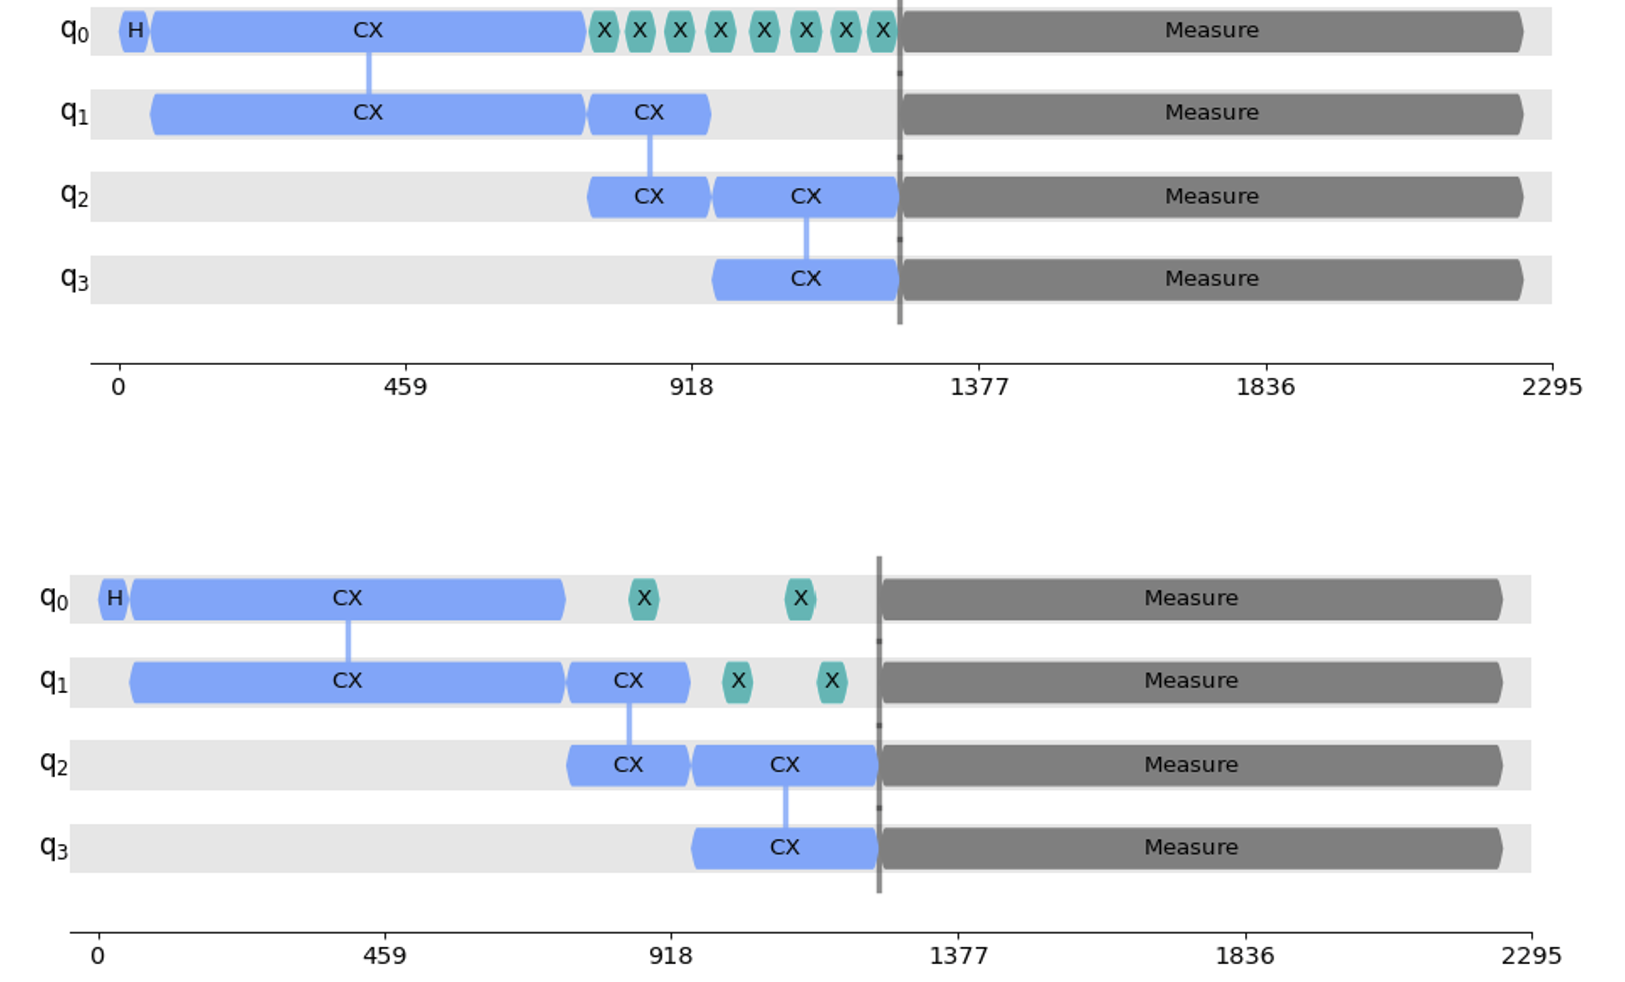


You can find more information about the dynamical decoupling [here](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager).


In [ ]:

circ = QuantumCircuit(5)
circ.h(0)
circ.ecr(0, 1)
circ.ecr(1, 2)
circ.ecr(2, 3)
circ.ecr(3, 4)
circ.measure_all()

#transpiled_qasm, initial_mapping = q.compile(qasm=dumps(circ), compilation_name="qiskit_3")
#transpiled_circ = QuantumCircuit.from_qasm_str(transpiled_qasm)
target = noisy_simulator.target
basis_gates = list(target.operation_names)

pm = generate_preset_pass_manager(3, target=target, seed_transpiler=12345)
transpiled_circ = pm.run(circ)

transpiled_circ.draw("mpl", idle_wires=False, fold=60)

In [ ]:
circuit_dd = apply_dd(noisy_simulator, transpiled_circ)
timeline_drawer(circuit_dd, show_idle=False)


In [ ]:
circuit_dd.draw("mpl", idle_wires=False, fold=60)

In [ ]:
job = noisy_simulator.run(circuit_dd, shots=10000)
result = job.result()  
output = result.get_counts()
output_normalize = normalize_counts(output, shots=shots)
output

In [ ]:
circ_dd.draw("mpl")

In [ ]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions, SamplerOptions
)

In [ ]:
## DD
options = SamplerOptions(
    default_shots=5000,
    dynamical_decoupling={
        'enable':True, 
        'sequence_type':'XpXm', 
        'extra_slack_distribution':'middle',
        'scheduling_method':'alap'},
    execution={
        'init_qubits':True,
         #'rep_delay':
    },
    twirling={
        'enable_gates': False, 
        'enable_measure': True,
        'num_randomizations':'auto',
        'shots_per_randomization':'auto',
        'strategy':'all'
    }
) 

In [ ]:
sampler = Sampler(mode=backend_service, options=options)

In [ ]:
qasm = QiskitCircuit(dumps(circ))
compiled_circuit = qasm.transpile_to_target_backend(q.backend)

In [ ]:
sampler.run([compiled_circuit])

### Zero Noise Extrapolation (ZNE)

In [ ]:
durations = InstructionDurations.from_backend(backend_service)


In [ ]:
durations.get('id', (3,))

In [ ]:
durations.duration_by_name_qubits[('id', (0, ))][1]

In [ ]:
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ECRGate
from qiskit.circuit.library import RZXGate
from mitiq import zne
from mitiq.interface import convert_to_mitiq

theta = np.pi / 2
rzx_gate = RZXGate(theta)

def rzx_gate(circuit, control, target):
    #h q1; cx q0,q1; rz(pi/4) q1; cx q0,q1; h q1;
    circuit.h(target)
    circuit.cx(control,target)
    circuit.rz(np.pi/4, target)
    circuit.cx(control,target)
    circuit.h(target)

def rzxt_gate(circuit, control, target):
    #h q1; cx q0,q1; rz(-pi/4) q1; cx q0,q1; h q1;
    circuit.h(target)
    circuit.cx(control,target)
    circuit.rz(-np.pi/4, target)
    circuit.cx(control,target)
    circuit.h(target)

def ecr_gate(circuit, control, target):
    # rzx(pi/4) q0,q1; x q0; rzxt(-pi/4) q0,q1; }
    rzx_gate(circuit, control, target)
    circuit.x(control)
    rzxt_gate(circuit, control, target)

def cx_to_ecr(circuit, control, target):
#sx q[0]; rz(-pi / 2) q[1]; rz(-pi / 2) q[0]; sx q[1]; rz(-pi) q[1]; ecr q[1], q[0];
#rz(-pi / 2) q[0]; rz(pi / 2) q[1]; sx q[0]; sx q[1]; rz(pi / 2) q[0]; rz(pi / 2) q[1];
    circuit.sx(control)
    circuit.rz(-np.pi/2, target)
    circuit.rz(-np.pi/2, control)
    circuit.sx(target)
    circuit.rz(-np.pi, target)
    ecr_gate(circuit, target, control)
    circuit.rz(-np.pi/2, control)
    circuit.rz(np.pi/2, target)
    circuit.sx(control)
    circuit.sx(target)
    circuit.rz(np.pi/2, control)
    circuit.rz(np.pi/2, target)
    
# Create a quantum circuit with ECR gates
n_qubits = 2
circuit = QuantumCircuit(2)
circuit.x(0)
circuit.barrier(0,1)
cx_to_ecr(circuit, 0, 1)
#circuit.cx(0,1)
#circuit.ecr(0,1)
circuit.measure_all()
circuit = transpile(circuit, basis_gates=["u3","cx"])

print(dumps(circuit))
circuit.draw("mpl", fold=60)

convert_to_mitiq(circuit)
